# 📘 IbPRIA 2025 - Data-Efficient Strategies for Object Detection

> 📌 **Note**: You can run this notebook on:
>
> - 💻 Your local machine (Python ≥ 3.8, see `requirements.txt`)
> - 🌐 [Google Colab](https://colab.research.google.com/github/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/blob/main/hands_on_notebook.ipynb)



## ⚙️ Preparation to Run This Notebook

To ensure faster training and better performance, it is recommended to use a **GPU** when running this notebook.

If you're using **Google Colab**, make sure the runtime is configured to use a **GPU** or **TPU**.

> 📌 You can change the runtime by going to:  
> `Runtime` → `Change runtime type` → Select **GPU** or **TPU**

⬇️ See the image below for guidance.

---

**Note:** You can also run this notebook **locally** using your own machine with **CPU only**.  
Training may be slower, but all code will still work correctly.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/colab_1.png)

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/colab_2_3.png)

In [22]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    print("✅ Running on Google Colab")
    # Clone the repository if running in Google Colab
    !git clone https://github.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection.git
    # Change working directory
    os.chdir("IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection")

%pip install -r requirements.txt # Install required packages

10325.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


## ✏️ Annotation Guidelines for Object Detection



In object detection tasks, each image must be labeled with **bounding boxes** that enclose every object the model is expected to detect. For each bounding box, a corresponding **class label** must be assigned.

There are several tools available for this annotation process:

- If you're working with a **small dataset** and need a lightweight solution, we recommend [labelImg](https://pypi.org/project/labelImg/).
- For **larger projects** with multiple annotators, we suggest using a more robust platform such as [Label Studio](https://labelstud.io/), which provide better support for collaboration.

### Bounding Box Best Practices

A bounding box is defined by its **center coordinates**, **width**, and **height**. For accurate annotations:

- The **center of the bounding box** should align with the center of the corresponding object.
- The edges of the bounding box should **not exceed the boundaries** of the object.
- Boxes should be **tight** but not overly precise — enough to capture the object clearly without including background noise.

> Ensuring consistent and accurate annotation is crucial, as it directly impacts the performance and reliability of the trained object detection model.

### Running LabelImg Locally

If you're running this notebook or working locally (not on Colab), you can install and launch **LabelImg** using the commands below:

```bash
pip install labelImg
```
**Important:** LabelImg works best with Python 3.9 or lower. Newer versions may cause compatibility issues. We recommend using a virtual environment with Python 3.9 if needed.

To lauch the tool:
```bash
labelImg
```

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/labelimg.png)

## 📏 Evaluation Metrics for Object Detection



Evaluating an object detection model involves multiple metrics that assess **localization accuracy**, **classification quality**, and **overall detection performance**. Below are the main metrics and how they apply to our use case:


### Intersection over Union (IoU)

**IoU** measures the overlap between the predicted bounding box and the ground truth box:

$\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$

A prediction is considered a **True Positive (TP)** if its IoU with a ground truth box is above a defined threshold $ \tau $. Otherwise, it’s a **False Positive (FP)**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/iou.png)



### Confusion Matrix

A confusion matrix summarizes the **classification performance** by showing how often each class is correctly or incorrectly predicted:

- **TP**: Correctly detected objects  
- **FP**: Incorrect predictions  
- **FN**: Missed detections  

In object detection, this matrix is typically based on **IoU-matched predictions**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/confusion_matrix.png)


### Precision & Recall

These metrics quantify how accurate and complete the model’s predictions are:

- **Precision** = TP / (TP + FP)  
- **Recall** = TP / (TP + FN)



### Average Precision (AP) and mAP

**Average Precision (AP)** is computed as the area under the Precision–Recall curve, computed by evaluating precision and recall across multiple confidence thresholds at a fixed IoU.  
**Mean Average Precision (mAP)** is the mean of APs across all classes or IoU thresholds.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/pr_curve.png)

In the example above:
- The class `WF` (Whitefly) achieves **0.931 mAP@0.5**, indicating excellent detection performance.


## 📂 Dataset Format for YOLO Training


To train a YOLO model, your dataset must follow a specific structure and include a `.yaml` configuration file that defines where your images and annotations are located, along with the list of classes.

---

### Folder Structure

Each image should have a corresponding `.txt` annotation file with the same name (e.g., `image1.jpg` ↔ `image1.txt`), and these should be placed in the appropriate subfolders.

```text
dataset/
├── train/
├── val/
├── test/
└── data.yaml
```

> **Note:** YOLO expects labels in `.txt` format where each line corresponds to one bounding box, with the format:
>
> ```
> <class_id> <x_center> <y_center> <width> <height>
> ```
> All values must be normalized (from 0 to 1) relative to image size.

---

### `data.yaml` Example

```yaml
train: dataset/train/images
val: dataset/val/images
test: dataset/test/images

nc: 1  # number of classes
names: ['WF'] #name of the class that MUST match the <class_id> in the annotation file
```

## 👁️ Object Detection with YOLOv11


Once your dataset is prepared and organized correctly, you can begin training your YOLOv11 model. In this example, we’ll use the **nano version** of YOLOv11 (`yolov11n.pt`) and train on a custom dataset.


### Step 1: Dataset Splitting

We use a utility function to split the dataset into **training** and **validation** sets, assuming a separate **test set** already exists.

This example splits a dataset of 200 images into:
- **60% for training**
- **20% for validation**
- The remaining **20% are reserved as the test set**

In [23]:
from utils import get_split, split_dataset

# Get train/val split from dataset (test already fixed)
train, val = get_split(train_size=0.6, val_size=0.2, dataset_size=200)

# Save to dataset/run/train and dataset/run/val
split_dataset(train_split=train, val_split=val)
print("Train and validation splits saved successfully.")

Train and validation splits saved successfully.


### Step 2: Model Training

After the dataset splitting process, it is important to define the training parameters.

Some important parameters to define are: **image size**, number of **epochs**, how to initialize the model **weights**, and the **batch size**.

Let us clarify each of them:

**Image size** refers to the resolution to which every input image is resized before being fed into the yolov11 model. This fixed-size input is necessary because the model architecture (fully convolutional with final dense layers) expects inputs of the same size.

An **epoch** is one complete pass through the entire training dataset by the learning algorithm.

Pre-trained **weights** are obtained by training a model on a large dataset before applying it to a specific task. This approach leverages **transfer learning**, allowing the model to take advantage of already learned general features such as edges, textures, or shapes. We will further explore **transfer learning** and its advantages.

Finally, **batch size** is the number of training samples processed before the model updates its weights.

For each batch:
- The model makes predictions.
- The loss is computed.
- The optimizer adjusts weights using gradients from that batch.

In [24]:
from utils import train_yolo

project = "example_simple_detector" # Project directory for saving results

name = "yolov11n_custom"

image_size = 1280 # Image size for training
epochs = 10 # Number of epochs for training
batch_size = 4 # Batch size for training

# Train the YOLO model
trained = train_yolo(
    img=image_size, # Image size
    epochs=epochs, # Number of epochs
    data="dataset/data.yaml", # Path to data configuration file
    weights="yolo11n.pt", # Pre-trained weights from COCO dataset
    batch=batch_size, # Batch size
    name=name, # Name of the training run
    project=project # Project directory for saving results
)

Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 1298.63it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7902.8±1068.0 MB/s, size: 748.8 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 2066.01it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache


Plotting labels to example_simple_detector/yolov11n_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to example_simple_detector/yolov11n_custom
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.166      3.361      1.042        221       1280: 100%|██████████| 30/30 [01:53<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]

                   all         40       1932     0.0113     0.0704    0.00987    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.779      1.992     0.9148        100       1280: 100%|██████████| 30/30 [01:49<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

                   all         40       1932     0.0588      0.365      0.231     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       1.83       1.89     0.9192        101       1280: 100%|██████████| 30/30 [01:47<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:18,  4.51s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:14,  4.84s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 3/5 [00:14<00:10,  5.03s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:19<00:04,  4.86s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.83s/it]

                   all         40       1932      0.506      0.537      0.472      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.858       1.78     0.9515        138       1280: 100%|██████████| 30/30 [01:44<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:18,  4.52s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:14,  4.88s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 3/5 [00:14<00:10,  5.06s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:19<00:04,  4.90s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]

                   all         40       1932      0.639       0.46      0.503       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.774      1.711     0.9285        232       1280: 100%|██████████| 30/30 [01:50<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:18,  4.62s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:13,  4.63s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:18<00:04,  4.50s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.60s/it]

                   all         40       1932      0.694      0.633       0.69      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.637      1.608     0.9065        123       1280: 100%|██████████| 30/30 [01:52<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:17,  4.36s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:13,  4.64s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         40       1932      0.717      0.672      0.734      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.572      1.482     0.8979        228       1280: 100%|██████████| 30/30 [01:43<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.93s/it]

                   all         40       1932      0.742      0.709      0.782       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.534      1.416     0.8966        116       1280: 100%|██████████| 30/30 [01:42<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

                   all         40       1932      0.768       0.73      0.805      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.523      1.401     0.8807        214       1280: 100%|██████████| 30/30 [01:42<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

                   all         40       1932      0.779      0.744      0.822      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.448      1.291     0.8887        618       1280: 100%|██████████| 30/30 [01:47<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

                   all         40       1932      0.798      0.738      0.826      0.504



10 epochs completed in 0.353 hours.
Optimizer stripped from example_simple_detector/yolov11n_custom/weights/last.pt, 5.6MB
Optimizer stripped from example_simple_detector/yolov11n_custom/weights/best.pt, 5.6MB

Validating example_simple_detector/yolov11n_custom/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


                   all         40       1932      0.797      0.739      0.826      0.504
Speed: 3.8ms preprocess, 166.4ms inference, 0.0ms loss, 153.7ms postprocess per image
Results saved to example_simple_detector/yolov11n_custom


### Step 3: Detection with the Trained Model

Once your model has been trained, you can use it to detect objects in new images.

Below is an example of how to **load your trained YOLOv11 model**, run inference on a single image, and **visualize the results** using `OpenCV` and `matplotlib`.

In [ ]:
from utils import detect_yolo
import os
from IPython.display import Image, Video, display

file_to_detect = 'examples/example_video.mp4'  # or use an image like 'dataset/improved/2.jpg'
# file_to_detect = 'dataset/improved/2.jpg'

# Run detection using the trained YOLO model
results = detect_yolo(
    source=file_to_detect,
    weights=f"{project}/{name}/weights/best.pt",
    img=image_size,
)

# Get the output path
output_dir = results[0].save_dir  # YOLO typically saves to 'runs/detect/<name>/'
file_name = os.path.basename(file_to_detect)
output_path = os.path.join(output_dir, file_name)

# Display output based on extension
if file_to_detect.lower().endswith(('.jpg', '.jpeg', '.png')):
    display(Image(filename=output_path))
elif file_to_detect.lower().endswith(('.mp4', '.mov', '.avi')) and "COLAB_RELEASE_TAG" not in os.environ: # Avoid displaying video in Colab
    display(Video(filename=output_path))
else:
    print(f"Unsupported file type: {file_to_detect}")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/388) /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/examples/example_video.mp4: 736x1280 16 Whiteflys, 118.8ms
video 1/1 (frame 2/388) /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/examples/example_video.mp4: 736x1280 15 Whiteflys, 120.0ms
video 1/1 (frame 3/388) /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/examples/example_

## 🤖 Active Learning

The goal of **Active Learning (AL)** is to select the **most relevant samples** to be labeled first and used to train a model.  
This approach is particularly useful when **labeling data is expensive or time-consuming**.

Even with a **small initial set of labeled data**, it is possible to train a baseline model.  
To improve the model further, we need more labeled data — but instead of labeling everything, **Active Learning helps prioritize** which samples to label.

### Active Learning Strategies

There are two main approaches to Active Learning:

#### Stream-Based Selective Sampling

- Unlabeled data points are processed **one at a time**.
- For each sample, the model must decide **immediately** whether to query its label or discard it.
- Useful when data arrives in real time or memory is limited.

#### Pool-Based Sampling

- The model evaluates a **pool of unlabeled data** all at once.
- Each sample is scored based on a **relevance criterion** (e.g., confidence, entropy).
- The **top-K most informative** samples are selected and labeled.
- This is the most commonly used method in practice.

In Pool-based the process works as follows:

##### 1. A model is trained on the current labeled dataset.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_1.png)

##### 2. The model is then used to evaluate the **unlabeled data**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_2.png)

##### 3. Based on its predictions, the model **scores all unlabeled samples** using a selection strategy (e.g., uncertainty, disagreement, diversity).
   - Samples are then **ranked** by relevance.
   - Common scoring strategies include:
     - **Uncertainty sampling**: Select samples with the lowest confidence (highest uncertainty).
     - **Diversity sampling**: Choose a diverse set of samples to maximize information gain and avoid redundancy.
     - **Representativeness**: Pick samples that best represent the distribution of the overall data.
     - **Entropy-based sampling**: Select samples with the highest prediction entropy (more confusion between classes).

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_3.png)

##### 4. Based on the ranking, the **top-K most relevant samples are selected, labeled by an expert, and added to the labeled set**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_4.png)

##### 5. This cycle repeats, improving the model efficiently while **minimizing annotation effort**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_5.png)

---

By focusing labeling efforts on the **most informative samples**, Active Learning enables more efficient training and faster model improvement.

### Experiment Preparation

In this section, we evaluate the impact of **Active Learning (AL)** in a Pool-based scenario by training and comparing **two models**:

##### Incremental Training Strategy

Both models are trained **incrementally**:

- Training begins with a **small subset** of images for training and validation.
- At each iteration, a **new batch of data** is added to the training and validation sets.
- A new model is trained after each update.
- This process is repeated for a fixed number of iterations, defined by the variable `num_batches`.

The number of images added in each iteration is determined by:

- `batch_train_proportion * dataset_size` for training images
- `batch_val_proportion * dataset_size` for validation images

---

##### Model Variants

- **Active Learning Model:**  
  Selects new images based on **model uncertainty**, e.g., low confidence in predictions. This ensures the **most informative** samples are used in training in first place.

- **Random Selection Model:**  
  Selects new images **randomly** from the unlabeled pool at each iteration, serving as a baseline for comparison.

---

##### ⚙️ Key Parameters

- `num_batches`: Number of incremental iterations (rounds of training)
- `batch_train_proportion`: Proportion of the dataset used for training in each batch
- `batch_val_proportion`: Proportion of the dataset used for validation in each batch

These parameters control **how much data is added per iteration** and ensure both models grow in training size at the same pace, allowing for a fair comparison.

---

📈 At the end of the experiment, we compare the models using their **mAP@50** scores across iterations to evaluate which strategy learns more efficiently.

In [1]:
from utils import get_split, split_dataset, new_batch, train_yolo, test_yolo
import pandas as pd
from IPython.display import clear_output

# -------- Dataset setup --------
# Define dataset parameters

dataset_size = 200 # Total number of images in the dataset
num_batches = 8 # Number of batches to process
batch_train_prop = 0.6 / num_batches # Proportion of images in each batch for training (60% of the dataset)
batch_val_prop = 0.2 / num_batches # Proportion of images in each batch for validation (20% of the dataset)

num_epochs = 5 # Number of epochs for each training run
batch_size = 4 # Batch size for training
image_size = 608 # Image size for detection

# Project base
project = "example_active_learning" # Base project directory for saving results
base_weights = "yolo11n.pt" # Pre-trained weights to start training from

results_df = pd.DataFrame(index=range(num_batches)) # DataFrame to store results

# -------- Initial split --------
# Get initial train/val split for the first batch 
# this will ensure both models start with the same initial data
initial_train_split, initial_val_split = get_split(
                train_size=batch_train_prop,
                val_size=batch_val_prop,
                dataset_size=dataset_size
            ) 

### Model Training

,al mAP (test),random mAP (test)
0,0.000260,0.000260
1,0.011948,0.004751
2,0.021350,0.021636
3,0.111487,0.080489
4,0.131083,0.161272
5,0.287208,0.299778
6,0.362823,0.356262
7,0.356412,0.309008


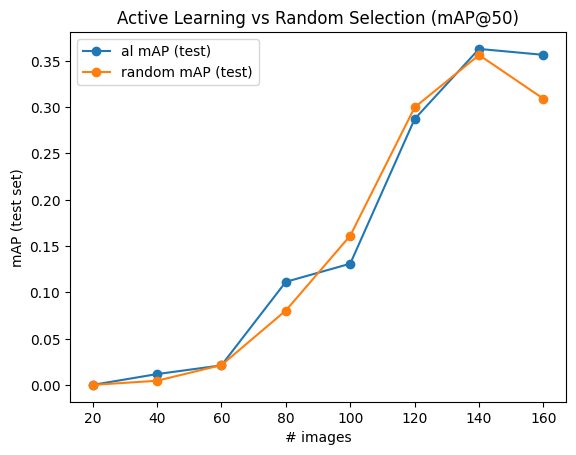

In [3]:
# Define a function to run a full mode (AL or random)
def run_training_loop(mode="al"):

    for batch in range(num_batches): # Loop through each batch
        print(f"\n=== Batch {batch} / {num_batches} — Mode: {mode} ===")
        name = f"{mode}_batch_{batch}" # Name for the current batch run (directory)

        if batch == 0: # First batch, use initial split
            split_dataset(train_split=initial_train_split, val_split=initial_val_split)
        else: # Subsequent batches, select new data
            new_batch(
                random=(mode == "random"), # Random selection if mode is "random"
                al="confidence", # Use confidence-based selection for active learning (other opriont: "count" - selected images with the most detections)
                weights=weights, # Weights from the previous batch
                train_images=int(batch_train_prop * dataset_size),
                val_images=int(batch_val_prop * dataset_size),
                project=f"{project}_{mode}/detecting",
                name=name,
                dataset="original",
                img_size=image_size
            )
        
        # Train the YOLO model with the selected data
        results = train_yolo(
            img=image_size,
            epochs=num_epochs,
            data="dataset/data.yaml",
            weights=base_weights, # Use base weights for training (always start from scratch)
            batch=batch_size,
            name=name,
            project=f"{project}_{mode}/training"
        )

        weights = f"{project}_{mode}/training/{name}/weights/best.pt" # Weights used to compute most relevant images in the next batch and for testing
        test_results = test_yolo(
            img=image_size,
            data="dataset/data.yaml",
            weights=weights, # Weights from the model trained in this batch
            project=f"{project}_{mode}/testing"
        )
        mAP_test = float(test_results.results_dict["metrics/mAP50(B)"])
        mAP = float(results.results_dict["metrics/mAP50(B)"])
        #results_df.loc[batch, f"{mode}_mAP"] = mAP
        results_df.loc[batch, f"{mode} mAP (test)"] = mAP_test
        print(f"✅ Batch {batch + 1} ({mode}) done — mAP@50: {mAP:.4f}")

# Run both modes
run_training_loop(mode="al")
run_training_loop(mode="random")

clear_output(wait=True)

# View combined results
display(results_df)
%matplotlib inline
results_df.plot(
    y=["al mAP (test)", "random mAP (test)"],
    marker='o',
    title="Active Learning vs Random Selection (mAP@50)"
)
import matplotlib.pyplot as plt
plt.xlabel("# images")
plt.ylabel("mAP (test set)")
plt.xticks(ticks=results_df.index, labels=[int((i+1)*(batch_train_prop+batch_val_prop)*dataset_size) for i in results_df.index])
plt.show()

## 🧹 Data Quality

In object detection, **annotation quality** plays a critical role in model performance.

Unlike classification tasks, object detection requires:
- The correct **label** for each object
- A precise **bounding box** tightly enclosing the object


### Common Annotation Issues

- **Incorrect Labels**: The object is mislabeled or assigned the wrong class.
- **Poor Bounding Boxes**:
  - Boxes do not align with the object
  - Boxes are too loose or too tight
  - Boxes include multiple objects
- **Inconsistent Annotations** across similar samples

Such errors often stem from:
- **Repetitive labeling** tasks
- **Fatigue** or insufficient training of annotators

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/data_quality.png)

### Annotation Quality Example: Original vs Improved Labels

As an illustration of the importance of annotation quality, this notebook includes **two versions of the same dataset**:

- `dataset/original/`: Contains the original annotations
- `dataset/improved/`: Contains refined, higher-quality annotations

Both versions share the **same images**, but differ in the accuracy and consistency of their bounding boxes and labels.

This allows us to analyze:
- How labeling precision impacts training performance
- Whether better annotations lead to **higher mAP** and more reliable predictions

By training the same model on each version, we can measure how much improvement is achieved **purely through better annotations** — without changing the model architecture or training strategy.

> This is especially useful in real-world projects, where annotation time is expensive, and correcting label errors can be more effective than adding more data.

#### Experimentation Preparation

In this experiment, **two models are trained using the same set of images**, but with **different annotations**.  
This setup is designed to evaluate the impact of **annotation quality** on the performance of an object detection model.

- Both models share the **same training and validation splits**, ensuring a fair and controlled comparison.
- The only difference lies in the annotations:
  - One model uses the **original** annotation set.
  - The other uses a set of **improved** annotations.

---

At the end of training, we compare the models using the **mAP@50 metric** to assess how annotation quality affects detection performance.

In [6]:
from utils import get_split, split_dataset, train_yolo, test_yolo
from IPython.display import clear_output
from IPython.display import display, Markdown

# Get train/val split from dataset (test already fixed)
train_split, val_split = get_split(
    train_size=0.6,
    val_size=0.2,
    dataset_size=200
)

image_size = 608 # Image size for training
num_epochs = 5 # Number of epochs for training
batch_size = 4 # Batch size for training

#### Model Training

In [7]:
def train_and_test_yolo(name):
    # Train and test YOLO model with original annotations
    train_yolo(
        img=image_size,
        epochs=num_epochs,
        data="dataset/data.yaml",
        weights="yolo11n.pt",
        batch=batch_size,
        name=name,
        project="example_data_quality/train"
    )
    
    map_results = test_yolo(
        img=image_size,
        data="dataset/data.yaml",
        weights=f"example_data_quality/train/{name}/weights/best.pt",
        project="example_data_quality/test"
    )
    
    return float(map_results.results_dict["metrics/mAP50(B)"])

#---------- Original Annotations ----------

# Preparing the dataset with the original annotaions
split_dataset(train_split=train_split, val_split=val_split, dataset="original") 
# Train and test the model with original annotations
map_original = train_and_test_yolo("original")

#---------- Improved Annotations ----------

# Preparing the dataset with the improved annotaions
split_dataset(train_split=train_split, val_split=val_split, dataset="improved") # Preparing the dataset with the improved annotaions
# Train and test the model with improved annotations
map_improved = train_and_test_yolo("improved") # Train and test the model with improved annotations

#--------- Calculate improvement ---------

# Calculate the absolute and relative improvement in mAP
improvement = map_improved - map_original
# Calculate the percentage improvement
percent_improvement = (improvement / map_original) * 100 if map_original > 0 else float('inf')  # Avoid division by zero
# Clear training outputs
clear_output(wait=True)
# Display the results in a Markdown format
display(Markdown(f"""
---
### **Annotation Quality Comparison**

- <span style="color:crimson"><b>mAP with original annotations:</b></span> <code>{map_original:.4f}</code>
- <span style="color:seagreen"><b>mAP with improved annotations:</b></span> <code>{map_improved:.4f}</code>

**Absolute improvement:** <b style="color:royalblue">{improvement:.4f} mAP@50</b>  
**Relative improvement:** <b style="color:royalblue">{percent_improvement:.2f}%</b>
"""))



---
### **Annotation Quality Comparison**

- <span style="color:crimson"><b>mAP with original annotations:</b></span> <code>0.3325</code>
- <span style="color:seagreen"><b>mAP with improved annotations:</b></span> <code>0.3465</code>

**Absolute improvement:** <b style="color:royalblue">0.0140 mAP@50</b>  
**Relative improvement:** <b style="color:royalblue">4.22%</b>


## 🧠 Transfer Learning

Training object detection models from scratch can be time-consuming and data-hungry. To overcome this, we use **Transfer Learning (TL)** — a technique that leverages a model pre-trained on a large dataset (e.g., COCO) and adapts it to our custom task.


#### What Can Change?

- The model’s **detection head** (final layers) is updated to match the number of classes in our current dataset.
- During training, the model retains the **general visual features** it has already learned (e.g., shapes, textures), while adapting to our specific setting.

> Transfer Learning helps us build accurate models faster, even with relatively small datasets — by reusing knowledge from related tasks.


#### Why Use Transfer Learning?

- **Jump-start training** with already-learned features
- **Reduce training time**
- **Improve performance**, especially when labeled data is limited

### Reusing a YOLOv5 Model

#### Approach

In this tutorial, we leverage **Transfer Learning** by starting from a pre-trained **YOLOv5** model trained to detect **whiteflies in yellow sticky traps**:

`pre-trained/yellow_trap.pt`

Although the original model was trained on the **same task** (whitefly detection), it was collected in a **different environment**. This makes it an excellent candidate for fine-tuning on our custom data.

##### YOLOv5 pre-trained on:

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/tl_v5.png)

##### New Dataset

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/tl_new.png)

As seen in the images above, both scenarios contain **whiteflies**, but in different environments.  
A model trained on one of these image sets can be used as a **starting point** for training on the other, leveraging the benefits of **transfer learning**.

> Recent YOLO models (version 8 and above) are available through the **Ultralytics Python library**.  
> However, in this tutorial, we use a **pre-trained YOLOv5 model**, which is **not included** in the `ultralytics` package.

> Therefore, we need to **clone the YOLOv5 repository manually** to access its training and inference utilities.

> **Note:** The YOLOv5 repository is no longer actively maintained and may produce several warnings during training due to updates in related packages.  
> Despite this, it remains **fully functional** and suitable for our fine-tuning task.

#### Cloning YOLOv5 github repository

In [ ]:
!git clone https://github.com/ultralytics/yolov5

#### Experience Preparation

In this transfer learning experiment, we train **two distinct models** for comparison:

- **Model A:** Starts training using the weights of a **pre-trained YOLOv5** model  
- **Model B:** Trains **from scratch** using **YOLOv11n**, with no prior learning

Both models are trained using the **same dataset**, including:

- Identical **training and validation splits**
- Same **number of epochs**, **image size**, and **batch size**

---

At the end of training, a plot is displayed showing the **evolution of performance (mAP@50)** across epochs for both models, allowing us to visualize and compare their learning behavior.

In [ ]:
from utils import get_split, split_dataset, train_yolo, train_yolov5
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt

# Get train/val split from dataset (test already fixed 20%)
train_split, val_split = get_split(
    train_size=0.6, # 60 percent of the dataset for training
    val_size=0.2, # 20 percent of the dataset for validation
    dataset_size=200
)

# Images to be used for training and validation will be available in dataset/run
split_dataset(train_split=train_split, val_split=val_split, dataset="improved")

num_epochs = 5 # Number of epochs for training
batch_size = 4 # Batch size for training

#### Model Training

In [ ]:
# Train YOLOv5 with transfer learning using pre-trained weights
train_yolov5(
    img=1280, # pre-trained/yellow_trap.pt was trained on 1280x1280 images, so we use the same size
    epochs=num_epochs,
    data="dataset/data_yolov5.yaml",
    weights="pre-trained/yellow_trap.pt",  # Using YOLOv5 small as the pre-trained model
    batch=batch_size,
    name="transfer_learning",
    project="example_transfer_learning"
)

# Train YOLOv11 from scratch on the same dataset
train_yolo(
    img=1280,
    epochs=num_epochs,
    data="dataset/data.yaml",
    weights="yolo11n.yaml",
    batch=batch_size,
    name="baseline",
    project="example_transfer_learning/train"
)

clear_output(wait=True)

print("Training completed successfully. Results saved in 'example_transfer_learning/train/transfer_learning' and 'example_transfer_learning/train/baseline'.")

Training completed successfully. Results saved in 'example_transfer_learning/train/transfer_learning' and 'example_transfer_learning/train/baseline'.


#### Plot Comparison

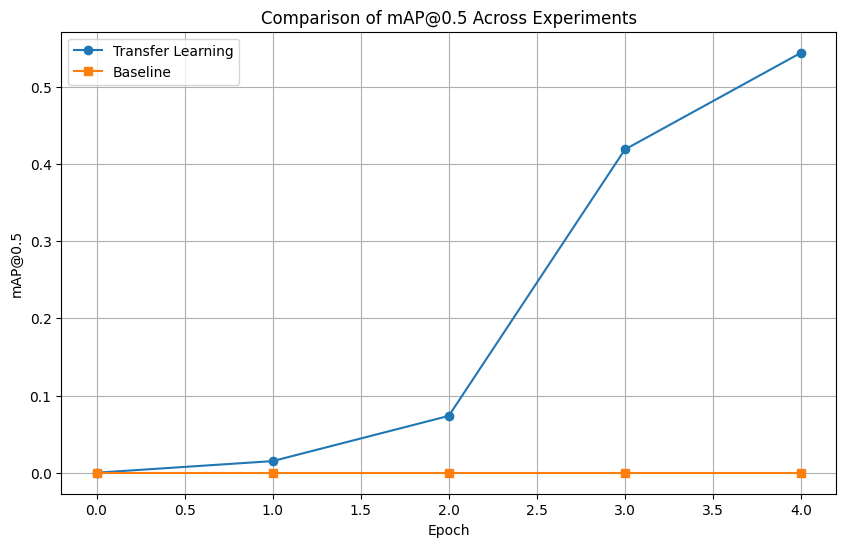

In [ ]:
df1 = pd.read_csv("example_transfer_learning/train/transfer_learning/results.csv")
df2 = pd.read_csv("example_transfer_learning/train/baseline/results.csv")

# Strip leading/trailing whitespace from column names
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

%matplotlib inline
# Plotting mAP@0.5
plt.figure(figsize=(10, 6))
plt.plot(df1['metrics/mAP_0.5'], label='Transfer Learning', marker='o')
plt.plot(df2['metrics/mAP50(B)'], label='Baseline', marker='s')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Comparison of mAP@0.5 Across Experiments')
plt.legend()
plt.grid(True)
plt.show()